In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn.utils.multiclass import unique_labels

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_forehand = '/content/drive/MyDrive/MyPadel/DIRITTI_ROVESCI_10-05/DIRITTI.txt'
path_backhand = '/content/drive/MyDrive/MyPadel/DIRITTI_ROVESCI_10-05/ROVESCI.txt'
path_smash = '/content/drive/MyDrive/MyPadel/SMASH_VOLLEY_10-05/SMASH.txt'
path_lob = '/content/drive/MyDrive/MyPadel/SMASH_VOLLEY_10-05/VOLLEY.txt'

##Functions

In [ ]:
def show_data(timestamp, x, y, z, start, end, title):
  plt.title("Stroke visualization " + title)
  timestamp = timestamp[start:end]
  x = x[start:end]
  y = y[start:end]
  z = z[start:end]
  plt.plot(timestamp, x)
  plt.plot(timestamp, y)
  plt.plot(timestamp, z)
  plt.xlabel("Timestamp")
  plt.ylabel("Amplitude")
  plt.legend(["x", "y","z"])
  plt.show()

def triangle_filter(n):
    f = np.zeros((1+2*n))
    for i in range(n):
        f[i] = i+1
        f[-i-1] = i+1
    f[n] = n + 1
    return f / np.sum(f)

def smooth(data, smoothing_window):
  filter = triangle_filter(smoothing_window)
  tmp = np.pad(data, smoothing_window, mode='edge')
  res = np.convolve(tmp, filter, mode='valid')
  return res

def frequency_reduction(data, reduction_factor):
  res = []
  for i in range(0, len(data), reduction_factor):
    sum = 0
    if i + reduction_factor > len(data):
      return res
    for j in range(reduction_factor):
      sum += data[i+j]
    res.append(sum/reduction_factor)

  return res



def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
acc = []
gyr = []

with open(path_forehand,'r') as file:
  line_array = file.readlines()
  feature_vec = []
  
  count = 0
  for l in line_array:
    l_array = l.split(";")
    feature_vec = []
    feature_vec.append(float(l_array[1])) # timestamp
    feature_vec.append(float(l_array[2])) # x
    feature_vec.append(float(l_array[3])) # y
    feature_vec.append(float(l_array[4])) # z  

    if float(l_array[0]) == 0.0:
      acc.append(feature_vec)
    else:
      gyr.append(feature_vec)



In [ ]:
x_acc = []
y_acc = []
z_acc = []
timestamp_acc = []

for vett in acc:
  x_acc.append(vett[1])
  y_acc.append(vett[2])
  z_acc.append(vett[3])
  timestamp_acc.append(vett[0])


In [ ]:
x_gyr = []
y_gyr = []
z_gyr = []
timestamp_gyr = []

for vett in gyr:
  x_gyr.append(vett[1])
  y_gyr.append(vett[2])
  z_gyr.append(vett[3])
  timestamp_gyr.append(vett[0])
  

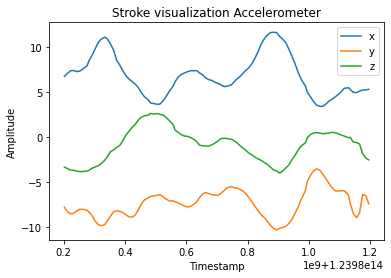

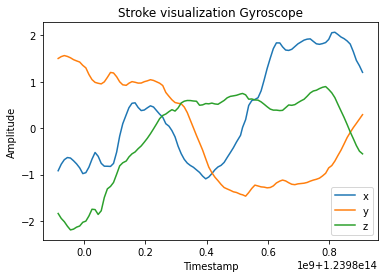

In [ ]:
start = 3200
end = 3300

show_data(timestamp_acc, x_acc, y_acc, z_acc, start, end, "Accelerometer")
show_data(timestamp_gyr, x_gyr, y_gyr, z_gyr, start, end, "Gyroscope")

In [ ]:
smoothing_window = 2

x_acc_smooth = smooth(x_acc, smoothing_window)
y_acc_smooth = smooth(y_acc, smoothing_window)
z_acc_smooth = smooth(z_acc, smoothing_window)

x_gyr_smooth = smooth(x_gyr, smoothing_window)
y_gyr_smooth = smooth(y_gyr, smoothing_window)
z_gyr_smooth = smooth(z_gyr, smoothing_window)

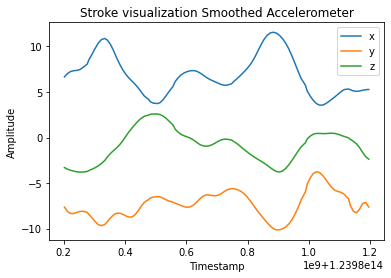

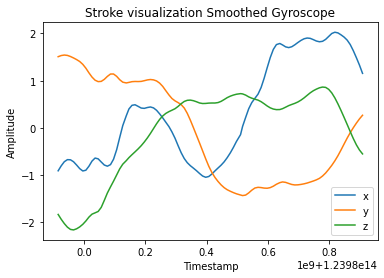

In [ ]:
show_data(timestamp_acc, x_acc_smooth, y_acc_smooth, z_acc_smooth, start, end, "Smoothed Accelerometer")
show_data(timestamp_gyr, x_gyr_smooth, y_gyr_smooth, z_gyr_smooth, start, end, "Smoothed Gyroscope")

In [ ]:
# reduction_factor = 2 means divide frequency by 2
reduction_factor = 4

timestamp_acc_red = frequency_reduction(timestamp_acc, reduction_factor)
x_acc_red = frequency_reduction(x_acc, reduction_factor)
y_acc_red = frequency_reduction(y_acc, reduction_factor)
z_acc_red = frequency_reduction(z_acc, reduction_factor)


timestamp_gyr_red = frequency_reduction(timestamp_gyr, reduction_factor)
x_gyr_red = frequency_reduction(x_gyr, reduction_factor)
y_gyr_red = frequency_reduction(y_gyr, reduction_factor)
z_gyr_red = frequency_reduction(z_gyr, reduction_factor)

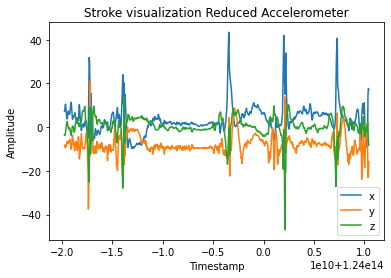

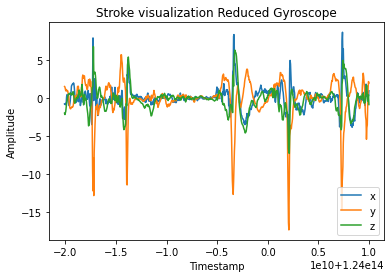

In [ ]:
start = 800
end = 1550
show_data(timestamp_acc_red, x_acc_red, y_acc_red, z_acc_red, start, end, "Reduced Accelerometer")
show_data(timestamp_gyr_red, x_gyr_red, y_gyr_red, z_gyr_red, start, end, "Reduced Gyroscope")

##Gradient in order to find a stroke

In [ ]:
x_acc_red_grad = np.gradient(x_acc_red)
y_acc_red_grad = np.gradient(y_acc_red)
z_acc_red_grad = np.gradient(z_acc_red)

grad_tot = []

for i in range(len(x_acc_red_grad)):
  grad_tot.append(math.sqrt(pow(x_acc_red_grad[i], 2) + pow(y_acc_red_grad[i], 2) + pow(z_acc_red_grad[i], 2)))


In [ ]:
x_gyr_red_grad = np.gradient(x_gyr_red)
y_gyr_red_grad = np.gradient(y_gyr_red)
z_gyr_red_grad = np.gradient(z_gyr_red)

grad_gyr_tot = []

for i in range(len(x_gyr_red_grad)):
  grad_gyr_tot.append(math.sqrt(pow(x_gyr_red_grad[i], 2) + pow(y_gyr_red_grad[i], 2) + pow(z_gyr_red_grad[i], 2)))


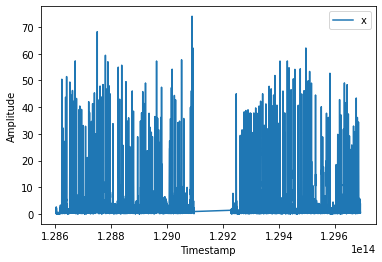

In [ ]:
start = 0
end = len(grad_tot)


timestamp_acc_red_fractionated = timestamp_acc_red[start:end]
grad_tot_fractionated = grad_tot[start:end]
plt.plot(timestamp_acc_red_fractionated, grad_tot_fractionated)
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.legend(["x", "y","z"])
plt.show()

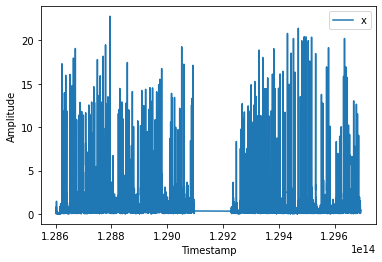

In [ ]:
start = 0
end = len(grad_gyr_tot)


timestamp_gyr_red_fractionated = timestamp_gyr_red[start:end]
grad_gyr_tot_fractionated = grad_gyr_tot[start:end]
plt.plot(timestamp_gyr_red_fractionated, grad_gyr_tot_fractionated)
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.legend(["x", "y","z"])
plt.show()

###Stroke detection

In [ ]:
window_lenght = 30
threshold = 10
min_interval = 30

max_indexes = []
max_values = []

max_index = 0
max_value = 0

for i in range(0, len(grad_tot_fractionated), window_lenght):
  if i + window_lenght > len(grad_tot_fractionated):
      break
  for j in range(window_lenght):
    if (grad_tot_fractionated[i+j] > max_value) and (grad_tot_fractionated[i+j] > threshold):
      max_value = grad_tot_fractionated[i+j]
      max_index = i+j
  if((max_value > 0) and (len(max_indexes) == 0)) or ((max_value > 0) and (max_index - max_indexes[-1] > min_interval)):
    max_indexes.append(max_index)
    max_values.append(max_value)
  max_index = 0
  max_value = 0


In [ ]:
print(max_indexes)

[518, 628, 738, 853, 942, 1229, 1303, 1463, 1537, 1613, 1706, 1818, 2039, 2114, 2269, 2346, 2418, 2622, 2788, 2837, 2902, 2976, 3147, 3250, 3347, 3409, 3551, 3659, 3730, 3913, 3981, 4169, 4379, 4499, 4602, 4709, 4798, 5056, 5526, 5596, 5651, 5833, 5932, 5967, 6209, 6320, 6445, 6549, 6685, 6765, 6869, 7246, 7498, 7598, 7699, 7776, 7850, 7943, 7990, 8099, 8257, 8325, 8459, 8558, 8784, 8924, 9015, 9104, 9204, 9247, 9310, 9359, 10087, 10164, 10242, 10308, 10504, 10609, 10815, 10964, 11146, 11338, 11937, 12017, 12075, 12148, 12728, 13085, 13161, 13249, 13307, 13435, 13582, 13677, 13769, 13966, 14035, 14158, 14295, 14369, 14456, 14558, 14756, 14894, 15073, 15223, 15359, 15509, 15650, 15830, 15934, 16048, 16166, 16346, 16482, 16616, 16879, 17036, 17267, 17419, 17600, 17801, 17936, 18237, 18417, 18539, 18755, 18915, 19115, 19247, 19408, 19551, 19769, 20286, 20404, 20476, 20746, 20916, 21051, 21610, 21652, 21748, 21913, 22046, 22254, 22340, 22451, 22584, 22690, 22787, 22993, 23152, 23266, 23394

In [ ]:

max_indexes_gyr = []
max_values_gyr = []

max_index_gyr = 0
max_value_gyr = 0

for acc_peak in max_indexes:
  start_search = acc_peak - 12
  for j in range(25):
    if (grad_gyr_tot_fractionated[start_search+j] > max_value_gyr):
      max_value_gyr = grad_gyr_tot_fractionated[start_search+j]
      max_index_gyr = start_search+j
  max_indexes_gyr.append(max_index_gyr)
  max_values_gyr.append(max_value_gyr)
  max_index_gyr = 0
  max_value_gyr = 0

In [ ]:
print(max_indexes_gyr)

[515, 625, 739, 853, 943, 1232, 1306, 1464, 1540, 1619, 1711, 1824, 2047, 2124, 2277, 2355, 2428, 2633, 2797, 2829, 2913, 2987, 3159, 3262, 3359, 3421, 3563, 3671, 3742, 3925, 3992, 4159, 4372, 4495, 4605, 4705, 4809, 5052, 5518, 5587, 5642, 5837, 5925, 5963, 6210, 6313, 6451, 6540, 6684, 6768, 6873, 7238, 7487, 7609, 7699, 7766, 7861, 7934, 7984, 8087, 8269, 8316, 8454, 8551, 8793, 8934, 9003, 9093, 9194, 9255, 9318, 9361, 10084, 10176, 10234, 10297, 10516, 10619, 10812, 10968, 11150, 11333, 11926, 12016, 12083, 12138, 12730, 13073, 13150, 13238, 13314, 13437, 13572, 13684, 13758, 13965, 14029, 14157, 14287, 14361, 14444, 14561, 14760, 14891, 15075, 15211, 15350, 15497, 15658, 15823, 15938, 16044, 16154, 16337, 16487, 16615, 16874, 17026, 17273, 17422, 17611, 17795, 17939, 18246, 18418, 18541, 18743, 18921, 19113, 19236, 19402, 19541, 19773, 20283, 20396, 20484, 20749, 20904, 21055, 21606, 21658, 21740, 21910, 22049, 22246, 22351, 22439, 22579, 22685, 22793, 22982, 23162, 23256, 23392

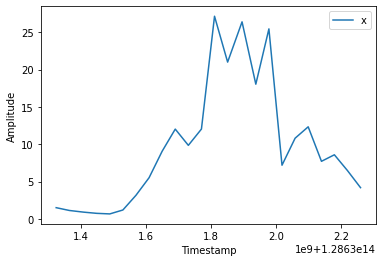

In [ ]:
stroke_mid_acc = max_indexes[2]
stroke_mid_gyr = max_indexes_gyr[2]
start = stroke_mid_acc - 12
end = stroke_mid_acc + 12

timestamp_acc_red_test = timestamp_acc_red[start:end]
grad_tot_test = grad_tot[start:end]
plt.plot(timestamp_acc_red_test, grad_tot_test)
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.legend(["x", "y","z"])
plt.show()

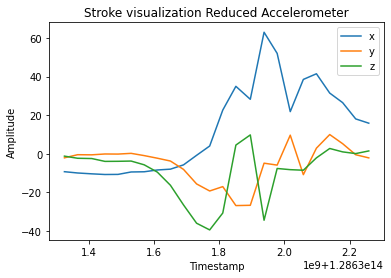

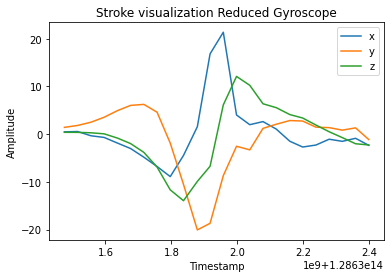

In [ ]:
show_data(timestamp_acc_red, x_acc_red, y_acc_red, z_acc_red, stroke_mid_acc - 12, stroke_mid_acc + 12, "Reduced Accelerometer")
show_data(timestamp_gyr_red, x_gyr_red, y_gyr_red, z_gyr_red,  stroke_mid_gyr - 12, stroke_mid_gyr + 12, "Reduced Gyroscope")

#Features Creation

In [ ]:
features = []
stroke_start_acc = 0
stroke_start_gyr = 0

temp = []

for i in range(len(max_indexes)):
  stroke_start = max_indexes[i] - 12
  stroke_start_gyr = max_indexes_gyr[i] - 12
  for j in range(25):
    temp.append(x_acc_red[j + stroke_start])
    temp.append(y_acc_red[j + stroke_start])
    temp.append(z_acc_red[j + stroke_start])
    temp.append(x_gyr_red[j + stroke_start_gyr])
    temp.append(y_gyr_red[j + stroke_start_gyr])
    temp.append(z_gyr_red[j + stroke_start_gyr])
  features.append(temp)
  temp = []

#np.save("features_lob", features)

[7.525427175000001, -9.243474125, 0.5012963425, -1.961409825, 1.842351475, -2.01910725, 9.907482, -6.7812595, 1.239482175, -2.098479575, 1.24492285, -1.9540832, 9.834501, -6.129215225, 0.760917625, -1.8057180999999998, 0.79616446, -1.789233125, 9.87039375, -3.6107693750000003, -0.24885356, -1.2635448, 0.3880080775, -1.750768125, 10.8753785, -2.9671, -0.953539825, -0.73449837, -0.15569167574999998, -1.7165770500000002, 12.343375875000001, -2.7936204499999997, -1.567298825, 0.010990000675000002, -0.8981272575, -1.572485875, 14.946766499999999, -2.508874575, -2.02313155, 0.6429150275, -1.8417409, -1.3172736999999999, 23.810978249999998, -2.8809584499999996, -3.16450805, 1.602403125, -3.3073795500000003, -0.8798105775, 35.082369, -1.1162517900000002, -1.684547175, 2.032539525, -6.3748107, -0.004273884999999991, 44.477787, 2.567498775, 2.1702901, 4.022950649999999, -9.800333249999998, 0.6487153075000001, 46.967519, 2.0937198, -4.8382874000000005, 6.50943835, -12.20347975, 1.448848375, 41.05

In [ ]:
features_forehand = np.load("/content/drive/MyDrive/MyPadel/features_diritti.npy")
features_backhand = np.load("/content/drive/MyDrive/MyPadel/features_rovesci.npy")
features_smash = np.load("/content/drive/MyDrive/MyPadel/features_smash.npy")
features_lob = np.load("/content/drive/MyDrive/MyPadel/features_lob.npy")

In [ ]:
forehand_train = features_forehand[0 : int(0.7*features_forehand.shape[0])]
forehand_test = features_forehand[int(0.7*features_forehand.shape[0]) : len(features_forehand)]

backhand_train = features_backhand[0 : int(0.7*features_backhand.shape[0])]
backhand_test = features_backhand[int(0.7*features_backhand.shape[0]) : len(features_backhand)]

smash_train = features_smash[0 : int(0.7*features_smash.shape[0])]
smash_test = features_smash[int(0.7*features_smash.shape[0]) : len(features_smash)]

lob_train = features_lob[0 : int(0.7*features_lob.shape[0])]
lob_test = features_lob[int(0.7*features_lob.shape[0]) : len(features_lob)]

In [ ]:
forehand_train_y = []
backhand_train_y = []
smash_train_y = []
lob_train_y = []

for i in range(len(forehand_train)):
  forehand_train_y.append([1,0,0,0])

for i in range(len(backhand_train)):
  backhand_train_y.append([0,1,0,0])

for i in range(len(smash_train)):
  smash_train_y.append([0,0,1,0])

for i in range(len(lob_train)):
  lob_train_y.append([0,0,0,1])

In [ ]:
X_train = np.concatenate((forehand_train, backhand_train, smash_train, lob_train), axis=0)
Y_train = np.concatenate((forehand_train_y, backhand_train_y, smash_train_y, lob_train_y))

In [ ]:
forehand_test_y = []
backhand_test_y = []
smash_test_y = []
lob_test_y = []

for i in range(len(forehand_test)):
  forehand_test_y.append([1,0,0,0])

for i in range(len(backhand_test)):
  backhand_test_y.append([0,1,0,0])

for i in range(len(smash_test)):
  smash_test_y.append([0,0,1,0])

for i in range(len(lob_test)):
  lob_test_y.append([0,0,0,1])

In [ ]:
X_test = np.concatenate((forehand_test, backhand_test, smash_test, lob_test), axis=0)
Y_test = np.concatenate((forehand_test_y, backhand_test_y, smash_test_y, lob_test_y))

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(4,activation='softmax'))
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=25)

Epoch 1/25
15/15 [==============================] - 1s 5ms/step - loss: 0.2792 - accuracy: 0.4022
Epoch 2/25
15/15 [==============================] - 0s 4ms/step - loss: 0.2406 - accuracy: 0.4891
Epoch 3/25
15/15 [==============================] - 0s 4ms/step - loss: 0.2038 - accuracy: 0.5652
Epoch 4/25
15/15 [==============================] - 0s 4ms/step - loss: 0.1173 - accuracy: 0.7435
Epoch 5/25
15/15 [==============================] - 0s 9ms/step - loss: 0.0947 - accuracy: 0.7935
Epoch 6/25
15/15 [==============================] - 0s 6ms/step - loss: 0.0791 - accuracy: 0.8283
Epoch 7/25
15/15 [==============================] - 0s 6ms/step - loss: 0.0650 - accuracy: 0.8522
Epoch 8/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0449 - accuracy: 0.8957
Epoch 9/25
15/15 [==============================] - 0s 7ms/step - loss: 0.0305 - accuracy: 0.9348
Epoch 10/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0237 - accuracy: 0.9500
Epoch 11/25
15/15

In [ ]:
model.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 4ms/step - loss: 0.1265 - accuracy: 0.7236


[0.1264876276254654, 0.7236180901527405]

In [ ]:
test_preds = model.predict(X_test)
y_pred = []
y_target = []
for i in range(len(test_preds)):
  y_pred.append(np.argmax(test_preds[i])) 
  y_target.append(np.argmax(Y_test[i]))
print("Testing Accuracy", accuracy_score(y_target, y_pred))

Testing Accuracy 0.7236180904522613


Normalized confusion matrix
[[0.70833333 0.04166667 0.         0.25      ]
 [0.01754386 0.75438596 0.         0.22807018]
 [0.0212766  0.06382979 0.89361702 0.0212766 ]
 [0.06382979 0.40425532 0.         0.53191489]]


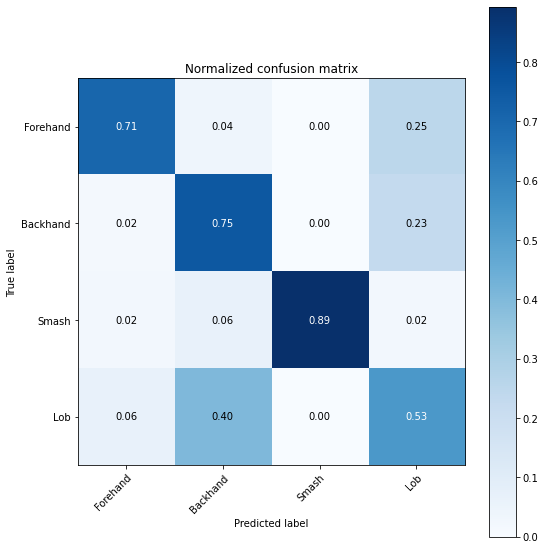

In [ ]:
cm = confusion_matrix(y_target,y_pred)
classes = np.array(['Forehand','Backhand','Smash', 'Lob'])
plot_confusion_matrix(y_target,y_pred,classes=classes)

In [ ]:
model.save("trained_model1")

INFO:tensorflow:Assets written to: trained_model1/assets


In [ ]:
!mv /content/trained_model1 /content/drive/MyDrive/MyPadel/

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [ ]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp9x1d1opr/assets


INFO:tensorflow:Assets written to: /tmp/tmp9x1d1opr/assets


In [ ]:
open("tflite_model.tflite", "wb").write(tflite_model)

80868

In [ ]:
interpreter=tf.lite.Interpreter(model_path="tflite_model")
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print ("Input Shape:", input_details[0]['shape'])
print ("Input Type:", input_details[0]['dtype'])
print ("Output Shape:", output_details[0]['shape'])
print ("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 150]
Input Type: <class 'numpy.float32'>
Output Shape: [1 4]
Output Type: <class 'numpy.float32'>
